Google cloud storage has much more capacity then a local "persistent" disk attached to a google cloud instance. Data stored in GCS is also permanent and can be accessed from any computer. If performing reductions of a very large dataset, it would be better to access the data directly from the cloud. Xarray provides tools for this.

This notebook demonstrates how to read a zarr file stored in the google cloud bucket.

In [1]:
%cd ../../

/home/noahb/workspace/fv3net


In [2]:
import xarray as xr
from src.data.advect import *


def replace_esmf_coords(ds):
    return ds.assign_coords(x=ds.lon.isel(y=0), y=ds.lat.isel(x=0))\
      .drop(['lat', 'lon'])\
      .rename({'x': 'lon', 'y': 'lat'})


In [3]:
ds = xr.open_zarr("data/interim/2019-07-17-FV3_DYAMOND_0.25deg_15minute_regrid_1degree.zarr/")
ds = ds.pipe(replace_esmf_coords)

In [4]:
z_c = height_centered(ds.dz, ds.zs)
qv_t = storage_fixed_height(ds.qv, z_c, ds.dz)
qv_adv = advection_fixed_height(ds, 'qv')
apparent_source = qv_t - qv_adv

def mass_integrate(phi, dp):
    gravity = 9.81
    return (phi * ds.dp/gravity).sum('pfull')

net_precitation = (-(apparent_source * ds.dp/9.81).sum('pfull')*86400).persist()

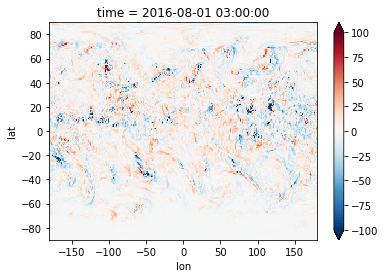

In [5]:
net_precitation[0].plot(vmax=100)

In [6]:
adv_int = mass_integrate(qv_adv, ds.dp).persist()

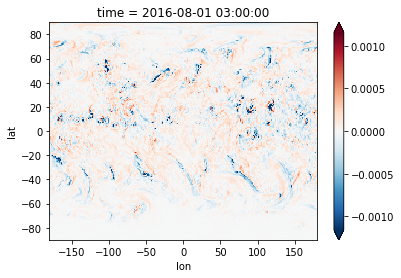

In [7]:
adv_int[0].plot(vmax=100/86400)

In [8]:
w_int = mass_integrate(qv_adv, ds.w).persist()

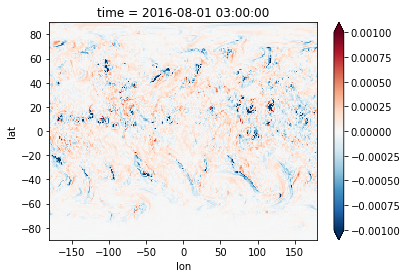

In [9]:
w_int[0].plot(vmax=1e-3)

This looks wrong. is dp < 0?

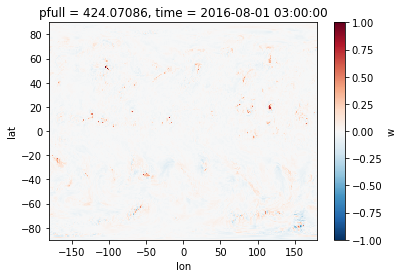

In [10]:
ds.w[0, -40].plot(vmax=1.0)

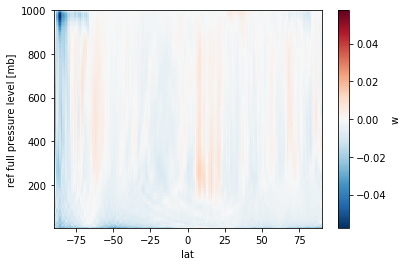

In [11]:
ds.w.mean(['lon', 'time']).plot(yincrease=True)

In [12]:
q2_mean = apparent_source.mean(['lon', 'time'])

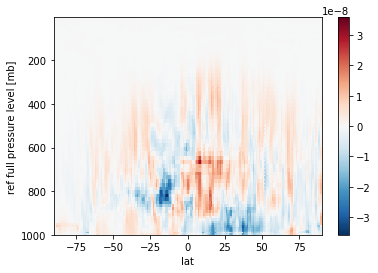

In [13]:
q2_mean.plot(yincrease=False)

This looks wrong. $Q_2 \approx w Q_z $, so $sgn(Q_2) = -sgn(w)$.

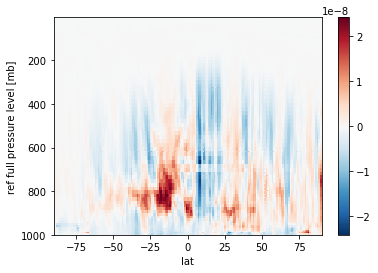

In [14]:
qv_adv.mean(['lon', 'time']).plot(yincrease=False)

The advection tendency has the wrong sign. It should be moistening in regions with vertical motion. Let's check what the advection term of height is. It should be $w.$

In [15]:
ds = ds.assign(z_c=z_c).load().chunk()

w_pred = advection_fixed_height(ds, 'z_c')

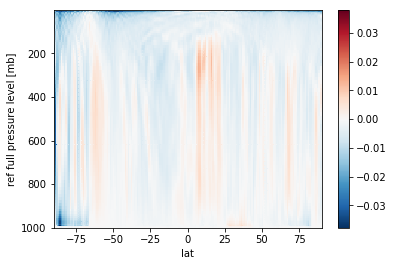

In [16]:
w_pred.mean(['lon', 'time']).plot(yincrease=False)

This seems correct.

# Conclusion

There was a sign error in my formula for Q2. The advection term is not the tendency but $\mathbf{v}\cdot \nabla \phi $. This is the correct version:

In [17]:
apparent_source = qv_t + qv_adv
net_precipitation = - mass_integrate(apparent_source*86400, ds.dp)

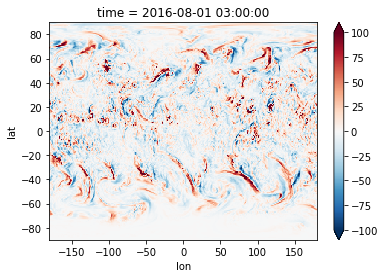

In [18]:
net_precipitation[0].plot(vmax=100)

This looks much better.